In [1]:
#@title Install dependencies (Colab)
!pip -q install pandas numpy scipy scikit-learn xgboost lightgbm shap requests joblib fastapi uvicorn streamlit matplotlib seaborn


In [2]:
#@title Helpers (TAP fetch & schema tools)
import io, requests, pandas as pd, numpy as np, json, os, joblib, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, classification_report, confusion_matrix

# Paths
DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)
ART_DIR  = Path("model_artifacts"); ART_DIR.mkdir(exist_ok=True)
REPORTS  = Path("reports"); REPORTS.mkdir(exist_ok=True)

# NASA TAP
TAP = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"
BKJD_OFFSET = 2454833.0  # BKJD -> BJD

def tap_csv(sql: str) -> pd.DataFrame:
    r = requests.get(TAP, params={"query": sql, "format": "csv"}, timeout=240)
    r.raise_for_status()
    return pd.read_csv(io.StringIO(r.text))

def first_existing(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns: return c
    return None

# Label maps
KOI_MAP = {"CONFIRMED":1, "CANDIDATE":1, "FALSE POSITIVE":0}
TOI_MAP = {"CP":1, "KP":1, "PC":1, "APC":0, "FP":0, "FA":0}

# Shared tabular features
CORE_FEATURES = [
    'period_days','dur_hrs','depth_ppm','rp_re','teq_k',
    'st_teff_k','st_logg_cgs','st_rad_rsun','st_mass_msun'
]


In [3]:
#@title Fetch KOI & TOI
koi_sql = """
SELECT kepid,kepoi_name,koi_disposition,koi_period,koi_time0bk,
       koi_duration,koi_depth,koi_prad,koi_teq,koi_steff,koi_slogg,koi_srad,koi_smass
FROM cumulative
"""
koi_raw = tap_csv(koi_sql)
koi_raw.to_csv(DATA_DIR/"koi_raw.csv", index=False)

toi_raw = tap_csv("SELECT * FROM toi")
toi_raw.to_csv(DATA_DIR/"toi_raw.csv", index=False)

koi_raw.head(2), toi_raw.head(2)


(      kepid kepoi_name koi_disposition  koi_period  koi_time0bk  koi_duration  \
 0  10797460  K00752.01       CONFIRMED    9.488036    170.53875        2.9575   
 1  10797460  K00752.02       CONFIRMED   54.418383    162.51384        4.5070   
 
    koi_depth  koi_prad  koi_teq  koi_steff  koi_slogg  koi_srad  koi_smass  
 0      615.8      2.26    793.0     5455.0      4.467     0.927      0.919  
 1      874.8      2.83    443.0     5455.0      4.467     0.927      0.919  ,
          tid      toi   toidisplay  toipfx    ctoi_alias  pl_pnum tfopwg_disp  \
 0   16288184  1049.01  TOI-1049.01    1049  1.628818e+07        1          KP   
 1  144065872   105.01   TOI-105.01     105  1.440659e+08        1          KP   
 
    st_tmag  st_tmagerr1  st_tmagerr2  ...  st_logglim   st_rad st_raderr1  \
 0  11.0657        0.006       -0.006  ...           0  1.27146   0.063558   
 1   9.4995        0.006       -0.006  ...           0  1.23824   0.059699   
 
    st_raderr2  st_radsymerr  st_

In [4]:
#@title Align/clean to common columns
koi = pd.read_csv(DATA_DIR/"koi_raw.csv")
toi = pd.read_csv(DATA_DIR/"toi_raw.csv")

# KOI alignment
koi_aligned = pd.DataFrame({
    "mission": "kepler",
    "obj_id": koi["kepoi_name"],
    "star_id": koi["kepid"],
    "label_raw": koi["koi_disposition"],
    "period_days": koi["koi_period"],
    "epoch_bjd": koi["koi_time0bk"] + BKJD_OFFSET,
    "dur_hrs": koi["koi_duration"],
    "depth_ppm": koi["koi_depth"],
    "rp_re": koi["koi_prad"],
    "teq_k": koi["koi_teq"],
    "st_teff_k": koi["koi_steff"],
    "st_logg_cgs": koi["koi_slogg"],
    "st_rad_rsun": koi["koi_srad"],
    "st_mass_msun": koi["koi_smass"],
})
koi_aligned["label"] = koi_aligned["label_raw"].map(KOI_MAP)

# TOI column auto-detect
tid  = first_existing(toi, ["tid","tic_id","ticid","tic"])
toiC = first_existing(toi, ["toi","ctoi_alias","toi_name"])
disp = first_existing(toi, ["tfopwg_disp","toidisposition","disposition","disp"])

per  = first_existing(toi, ["pl_orbper","orbital_period"])
tmid = first_existing(toi, ["pl_tranmid","transit_epoch"])
dur  = first_existing(toi, ["pl_trandurh","transit_duration"])
dep  = first_existing(toi, ["pl_trandep","transit_depth"])
rade = first_existing(toi, ["pl_rade","planet_radius"])
eqt  = first_existing(toi, ["pl_eqt","eq_temp"])
teff = first_existing(toi, ["st_teff","stellar_teff","teff"])
logg = first_existing(toi, ["st_logg","stellar_logg","logg"])
rad  = first_existing(toi, ["st_rad","stellar_radius","radius_star"])
mass = first_existing(toi, ["st_mass","stellar_mass","mass_star"])

missing_req = [n for n,c in [("tid",tid),("toi",toiC),("disp",disp)] if c is None]
if missing_req:
    raise RuntimeError(f"TOI table missing required id/label columns: {missing_req}\nFirst 30 cols: {list(toi.columns)[:30]}")

toi_aligned = pd.DataFrame({
    "mission": "tess",
    "obj_id": toi[toiC],
    "star_id": toi[tid],
    "label_raw": toi[disp],
    "period_days": toi[per]  if per  else np.nan,
    "epoch_bjd":   toi[tmid] if tmid else np.nan,
    "dur_hrs":     toi[dur]  if dur  else np.nan,
    "depth_ppm":   toi[dep]  if dep  else np.nan,
    "rp_re":       toi[rade] if rade else np.nan,
    "teq_k":       toi[eqt]  if eqt  else np.nan,
    "st_teff_k":   toi[teff] if teff else np.nan,
    "st_logg_cgs": toi[logg] if logg else np.nan,
    "st_rad_rsun": toi[rad]  if rad else np.nan,
    "st_mass_msun":toi[mass] if mass else np.nan,
})
toi_aligned["label"] = toi_aligned["label_raw"].map(TOI_MAP)

# Hygiene: drop impossible/NaN
def sane(df):
    df = df.dropna(subset=["label"]+CORE_FEATURES)
    df = df[(df["period_days"]>0) & (df["dur_hrs"]>0) & (df["depth_ppm"]>0)]
    return df

koi_aligned = sane(koi_aligned)
toi_aligned = sane(toi_aligned)

koi_aligned.to_csv(DATA_DIR/"koi_aligned.csv", index=False)
toi_aligned.to_csv(DATA_DIR/"toi_aligned.csv", index=False)

koi_aligned.shape, toi_aligned.shape


((9200, 15), (0, 15))

In [5]:
# --- REBUILD ALIGNED TABLES (robust TOI mapping; keep labeled rows) ---

import pandas as pd, numpy as np
from pathlib import Path

DATA_DIR = Path("data")
BKJD_OFFSET = 2454833.0  # Kepler BKJD -> BJD (epoch not used downstream, kept for completeness)

CORE_FEATURES = [
    'period_days','dur_hrs','depth_ppm','rp_re','teq_k',
    'st_teff_k','st_logg_cgs','st_rad_rsun','st_mass_msun'
]

# Label maps (string-insensitive)
KOI_MAP = {"CONFIRMED":1, "CANDIDATE":1, "FALSE POSITIVE":0}
TOI_MAP = {
    "CP":1, "KP":1, "PC":1, "CONFIRMED":1, "CONFIRMED PLANET":1,
    "APC":0, "FP":0, "FA":0, "FALSE POSITIVE":0, "FALSE ALARM":0
}

def norm(s):
    """Normalize disposition strings to canonical uppercase tokens."""
    if pd.isna(s): return None
    s = str(s).strip().upper()
    return {
        "CONFIRMED PLANET":"CONFIRMED",
        "PLANET CANDIDATE":"PC",
        "CANDIDATE":"PC",
        "FALSE ALARM":"FA",
        "FALSE-POSITIVE":"FALSE POSITIVE"
    }.get(s, s)

def first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def find_col(df, prefer=None, keywords=(), must_be_numeric=True):
    """
    prefer: exact names to try first
    keywords: tuple of substrings to score candidate columns
    must_be_numeric: require numeric dtype (or successful small-sample coercion)
    """
    if prefer:
        for p in prefer:
            if p in df.columns:
                return p
    cands = []
    for c in df.columns:
        score = sum(k in c for k in keywords)
        if score == 0:
            continue
        if must_be_numeric and not pd.api.types.is_numeric_dtype(df[c]):
            sample = pd.to_numeric(df[c].head(200), errors="coerce")
            if sample.notna().sum() < max(5, int(len(sample)*0.2)):
                continue
        cands.append((score, len(c), c))
    if not cands:
        return None
    cands.sort(key=lambda t: (-t[0], t[1], t[2]))
    return cands[0][2]

def col(df, name):
    """Safe column getter: returns series or NaNs if not found."""
    return df[name] if (name is not None and name in df.columns) else np.nan

# Load raw
koi_raw = pd.read_csv(DATA_DIR/"koi_raw.csv")
toi_raw = pd.read_csv(DATA_DIR/"toi_raw.csv")

# -------- KOI (Kepler) --------
koi_aligned = pd.DataFrame({
    "mission": "kepler",
    "obj_id": koi_raw["kepoi_name"],
    "star_id": koi_raw["kepid"],
    "label_raw": koi_raw["koi_disposition"],
    "period_days": koi_raw["koi_period"],
    "epoch_bjd": koi_raw["koi_time0bk"] + BKJD_OFFSET,
    "dur_hrs": koi_raw["koi_duration"],
    "depth_ppm": koi_raw["koi_depth"],
    "rp_re": koi_raw["koi_prad"],
    "teq_k": koi_raw["koi_teq"],
    "st_teff_k": koi_raw["koi_steff"],
    "st_logg_cgs": koi_raw["koi_slogg"],
    "st_rad_rsun": koi_raw["koi_srad"],
    "st_mass_msun": koi_raw["koi_smass"],
})
koi_aligned["label"] = koi_aligned["label_raw"].map(lambda x: KOI_MAP.get(norm(x)))
koi_aligned = koi_aligned[~koi_aligned["label"].isna()].reset_index(drop=True)

# -------- TOI (TESS) --------
toi = toi_raw.copy()
toi.columns = [c.strip().lower() for c in toi.columns]  # resilient lookup

# IDs / labels (broad aliasing)
tid  = find_col(toi, prefer=["tid","tic_id","ticid","tic","tic id"], keywords=("tic","tid","tic_id","ticid"), must_be_numeric=False)
toiC = find_col(toi, prefer=["toi","ctoi_alias","toi_name","toi id","toiid"], keywords=("toi",), must_be_numeric=False)
disp = find_col(toi, prefer=["tfopwg_disp","tfopwg_disposition","toidisposition","disposition","disp","final_disposition"],
                keywords=("disp","dispo","tfopwg","disposition"), must_be_numeric=False)

# Planet/stellar features (robust heuristics)
per  = find_col(toi, prefer=["pl_orbper","orbital_period","planet_orbital_period","p_orb","orbper"],
                keywords=("orb","per","period"))
dur  = find_col(toi, prefer=["pl_trandurh","transit_duration","duration_hours","t14_hours","durh","dur_hours"],
                keywords=("dur","t14","duration"))
dep  = find_col(toi, prefer=["pl_trandep","transit_depth","depth_ppm","depth"],
                keywords=("dep","depth","ppm"))
rade = find_col(toi, prefer=["pl_rade","planet_radius","rp_rearth","rp"],
                keywords=("rad","rp","radius"))
eqt  = find_col(toi, prefer=["pl_eqt","eq_temp","teq"],
                keywords=("eqt","eq_temp","teq"))
teff = find_col(toi, prefer=["st_teff","stellar_teff","teff"],
                keywords=("teff","stellar_teff","st_teff"))
logg = find_col(toi, prefer=["st_logg","stellar_logg","logg"],
                keywords=("logg","st_logg","stellar_logg"))
rad  = find_col(toi, prefer=["st_rad","stellar_radius","radius_star","rstar_rsun","st_rad_rsun"],
                keywords=("st_rad","stellar_radius","radius_star","rsun","rstar"))
mass = find_col(toi, prefer=["st_mass","stellar_mass","mass_star","mstar_msun","st_mass_msun"],
                keywords=("st_mass","stellar_mass","mass_star","msun","mstar"))
# (Optional) epoch (varies a lot; not used downstream)
tmid = find_col(toi, prefer=["pl_tranmid","t0_bjd","t0_btjd","t0","transit_epoch"],
                keywords=("tranmid","t0","epoch","btjd","bjd"), must_be_numeric=True)

print("MAPPED TOI COLUMNS:")
print(" tic_id:", tid, "\n toi:", toiC, "\n disp:", disp)
print(" period:", per, "\n dur:", dur, "\n depth:", dep, "\n rp_re:", rade, "\n teq_k:", eqt)
print(" teff:", teff, "\n logg:", logg, "\n st_rad:", rad, "\n st_mass:", mass)
if tmid is not None:
    print(" epoch_bjd-like:", tmid)

# If any required identifier/label missing, raise with context
missing_req = [n for n,c in [("tic_id",tid),("toi",toiC),("disposition",disp)] if c is None]
if missing_req:
    first_cols = list(toi.columns)[:60]
    raise RuntimeError(f"TOI missing required columns: {missing_req}\nFirst 60 cols: {first_cols}")

# Build aligned TOI using discovered columns
toi_aligned = pd.DataFrame({
    "mission": "tess",
    "obj_id": toi[toiC],
    "star_id": toi[tid],
    "label_raw": toi[disp],
    "period_days": col(toi, per),
    "epoch_bjd": col(toi, tmid),  # may be BTJD/BJD; unused by model
    "dur_hrs": col(toi, dur),
    "depth_ppm": col(toi, dep),
    "rp_re": col(toi, rade),
    "teq_k": col(toi, eqt),
    "st_teff_k": col(toi, teff),
    "st_logg_cgs": col(toi, logg),
    "st_rad_rsun": col(toi, rad),
    "st_mass_msun": col(toi, mass),
})

# Robust disposition mapping for TOI
toi_aligned["label"] = toi_aligned["label_raw"].map(lambda x: TOI_MAP.get(norm(x)))
toi_aligned = toi_aligned[~toi_aligned["label"].isna()].reset_index(drop=True)

# Coerce numerics for core features (do NOT drop by features here)
for c in CORE_FEATURES:
    koi_aligned[c] = pd.to_numeric(koi_aligned[c], errors="coerce")
    toi_aligned[c] = pd.to_numeric(toi_aligned[c], errors="coerce")

print("Kepler labeled rows:", len(koi_aligned))
print("TESS   labeled rows:", len(toi_aligned))
print("TESS rows with any NaN in core:",
      toi_aligned[CORE_FEATURES].isna().any(axis=1).sum())

# Save aligned (labeled-only)
koi_aligned.to_csv(DATA_DIR/"koi_aligned.csv", index=False)
toi_aligned.to_csv(DATA_DIR/"toi_aligned.csv", index=False)

koi_aligned.shape, toi_aligned.shape


MAPPED TOI COLUMNS:
 tic_id: tid 
 toi: toi 
 disp: tfopwg_disp
 period: pl_orbper 
 dur: pl_trandurh 
 depth: pl_trandep 
 rp_re: pl_rade 
 teq_k: pl_eqt
 teff: st_teff 
 logg: st_logg 
 st_rad: st_rad 
 st_mass: None
 epoch_bjd-like: pl_tranmid
Kepler labeled rows: 7585
TESS   labeled rows: 7703
TESS rows with any NaN in core: 7703


((7585, 15), (7703, 15))

In [6]:
# Physics-aware engineered features
from sklearn.preprocessing import StandardScaler
import numpy as np

DERIVED_FEATURES = [
    "depth_over_dur","rp_over_star","log_period","log_depth",
    "duty_cycle","star_rad_mass_ratio","rp_est_from_depth"
]

def build_features(df):
    X = df[['period_days','dur_hrs','depth_ppm','rp_re','teq_k',
            'st_teff_k','st_logg_cgs','st_rad_rsun','st_mass_msun']].copy()
    X["depth_over_dur"] = X["depth_ppm"] / (X["dur_hrs"] + 1e-9)
    X["rp_over_star"]   = X["rp_re"] / (X["st_rad_rsun"]*109.2 + 1e-9)
    X["log_period"]     = np.log1p(X["period_days"])
    X["log_depth"]      = np.log1p(X["depth_ppm"])
    X["duty_cycle"]     = X["dur_hrs"]/(24.0*X["period_days"] + 1e-9)
    X["star_rad_mass_ratio"] = X["st_rad_rsun"]/(X["st_mass_msun"] + 1e-9)
    X["rp_est_from_depth"]   = (X["depth_ppm"]/1e6)**0.5 * 109.2 * X["st_rad_rsun"]
    y = df["label"].astype(int).values
    return X, y


In [7]:
# --- CLEAN IMPUTE + REBALANCE + SCALE + TRAIN + THRESHOLDS (no leakage) ---

import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    classification_report, f1_score, precision_recall_curve, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import xgboost as xgb
from lightgbm import LGBMClassifier

# ==== 0) Load aligned tables (labeled-only) ====
koi_aligned = pd.read_csv(DATA_DIR/"koi_aligned.csv")
toi_aligned = pd.read_csv(DATA_DIR/"toi_aligned.csv")

# ==== 1) Impute RAW core features BEFORE feature engineering ====
CORE_FEATURES = [
    'period_days','dur_hrs','depth_ppm','rp_re','teq_k',
    'st_teff_k','st_logg_cgs','st_rad_rsun','st_mass_msun'
]

# If a TOI column is entirely missing, seed from KOI median
for c in CORE_FEATURES:
    if c not in toi_aligned.columns:
        toi_aligned[c] = np.nan
    if toi_aligned[c].isna().all():
        toi_aligned[c] = koi_aligned[c].median()

# Per-dataset coercion + median impute
for df in (koi_aligned, toi_aligned):
    for c in CORE_FEATURES:
        df[c] = pd.to_numeric(df[c], errors='coerce')
        df[c] = df[c].fillna(df[c].median())

# Clamp obviously positive quantities
pos_clamp = ["period_days","dur_hrs","depth_ppm","rp_re","st_rad_rsun","st_mass_msun","teq_k","st_teff_k"]
for df in (koi_aligned, toi_aligned):
    for c in pos_clamp:
        med = df[c].median()
        df.loc[df[c] <= 0, c] = med if np.isfinite(med) and med > 0 else 1.0

# ==== 2) Physics-aware features ====
def build_features(df):
    X = df[CORE_FEATURES].copy()
    X["depth_over_dur"] = X["depth_ppm"] / (X["dur_hrs"] + 1e-9)
    X["rp_over_star"]   = X["rp_re"] / (X["st_rad_rsun"]*109.2 + 1e-9)
    X["log_period"]     = np.log1p(X["period_days"])
    X["log_depth"]      = np.log1p(X["depth_ppm"])
    X["duty_cycle"]     = X["dur_hrs"]/(24.0*X["period_days"] + 1e-9)
    X["star_rad_mass_ratio"] = X["st_rad_rsun"]/(X["st_mass_msun"] + 1e-9)
    X["rp_est_from_depth"]   = (X["depth_ppm"]/1e6)**0.5 * 109.2 * X["st_rad_rsun"]
    y = df["label"].astype(int).values
    return X.replace([np.inf,-np.inf], np.nan), y

X_koi, y_koi = build_features(koi_aligned)
X_toi, y_toi = build_features(toi_aligned)

# ==== 3) Split TESS = 20% val / 80% test ====
X_val, X_test, y_val, y_test = train_test_split(
    X_toi, y_toi, test_size=0.80, random_state=42, stratify=y_toi
)

# ==== 4) Imputer fitted on KOI (no leakage) ====
imp = SimpleImputer(strategy="median").fit(X_koi)
X_koi_imp  = pd.DataFrame(imp.transform(X_koi),  columns=X_koi.columns)
X_val_imp  = pd.DataFrame(imp.transform(X_val),  columns=X_koi.columns)
X_test_imp = pd.DataFrame(imp.transform(X_test), columns=X_koi.columns)

# ==== 5) REBALANCE KOI with resample (upsample minority) ====
koi_imp_wy = X_koi_imp.copy()
koi_imp_wy["label"] = y_koi

n_pos = int((koi_imp_wy["label"]==1).sum())
n_neg = int((koi_imp_wy["label"]==0).sum())
print(f"[KOI before resample] pos={n_pos}, neg={n_neg}")

df_pos = koi_imp_wy[koi_imp_wy["label"]==1]
df_neg = koi_imp_wy[koi_imp_wy["label"]==0]

# Choose strategy: upsample minority to match majority
minority = df_pos if len(df_pos) < len(df_neg) else df_neg
majority = df_neg if len(df_neg) > len(df_pos) else df_pos
minority_up = resample(minority, replace=True, n_samples=len(majority), random_state=42)

koi_bal = pd.concat([majority, minority_up], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)
X_koi_bal = koi_bal.drop(columns=["label"]).values
y_koi_bal = koi_bal["label"].values

print(f"[KOI after resample]  pos={int((y_koi_bal==1).sum())}, neg={int((y_koi_bal==0).sum())}")

# ==== 6) Scale (fit on balanced KOI) ====
scaler = StandardScaler().fit(X_koi_bal)
Xs_koi  = scaler.transform(X_koi_bal)
Xs_val  = scaler.transform(X_val_imp)
Xs_test = scaler.transform(X_test_imp)

# ==== 7) Models (turn OFF class weights now that KOI is balanced) ====
xgb_base = xgb.XGBClassifier(
    n_estimators=700, max_depth=6, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9,
    scale_pos_weight=1.0,  # balanced
    objective="binary:logistic", eval_metric="logloss", random_state=42, n_jobs=4
)
lgb_base = LGBMClassifier(
    n_estimators=1200, num_leaves=63, learning_rate=0.03,
    subsample=0.9, colsample_bytree=0.9,
    class_weight=None,  # balanced
    random_state=42, n_jobs=-1
)
log_base = LogisticRegression(max_iter=5000, class_weight=None, n_jobs=-1)

# Fit on KOI (balanced, imputed, scaled)
xgb_base.fit(Xs_koi, y_koi_bal)
lgb_base.fit(Xs_koi, y_koi_bal)
log_base.fit(Xs_koi, y_koi_bal)

# ==== 8) Calibrate on TESS-val ====
xgb_cal = CalibratedClassifierCV(xgb_base, method="sigmoid", cv="prefit").fit(Xs_val, y_val)
lgb_cal = CalibratedClassifierCV(lgb_base, method="sigmoid", cv="prefit").fit(Xs_val, y_val)
log_cal = CalibratedClassifierCV(log_base, method="sigmoid", cv="prefit").fit(Xs_val, y_val)

# ==== 9) Pick threshold on TESS-val ====
def best_threshold_macro_f1(y_true, p):
    ths = np.linspace(0.05, 0.95, 181)
    scores = [f1_score(y_true, (p>=t).astype(int), average="macro") for t in ths]
    t = float(ths[int(np.argmax(scores))])
    return t, float(np.max(scores))

def threshold_at_fpr(y_true, p, target_fpr=0.10):
    fpr, tpr, thr = roc_curve(y_true, p)
    idx = np.where(fpr <= target_fpr)[0]
    if len(idx) == 0:  # fallback to smallest FPR available
        i = np.argmin(fpr)
        return float(thr[i]), float(fpr[i]), float(tpr[i])
    i = idx[-1]
    return float(thr[i]), float(fpr[i]), float(tpr[i])

def summarize(name, mdl, Xv, yv, Xt, yt):
    pv = mdl.predict_proba(Xv)[:,1]
    pt = mdl.predict_proba(Xt)[:,1]

    # Option A: threshold for target FPR on VAL
    t_fpr, fprv, tprv = threshold_at_fpr(yv, pv, target_fpr=0.10)
    # Option B: threshold maximizing macro-F1 on VAL
    t_f1, f1v = best_threshold_macro_f1(yv, pv)

    def eval_at(t, p, y):
        yhat = (p>=t).astype(int)
        return {
            "auc": float(roc_auc_score(y, p)),
            "ap":  float(average_precision_score(y, p)),
            "acc": float(accuracy_score(y, yhat)),
            "report": classification_report(y, yhat, digits=4, output_dict=False)
        }

    res_fpr = eval_at(t_fpr, pt, yt)
    res_f1  = eval_at(t_f1,  pt, yt)

    print(f"\n{name} — thresholds from VAL")
    print(f"  • target FPR≈10%: thr={t_fpr:.3f}  (VAL FPR={fprv:.3f}, TPR={tprv:.3f})")
    print(f"  • best macro-F1 : thr={t_f1:.3f}  (VAL macro-F1={f1v:.3f})")

    print("\n  >> TEST @ target-FPR threshold")
    print(f"     AUC={res_fpr['auc']:.4f}  AP={res_fpr['ap']:.4f}  ACC={res_fpr['acc']:.4f}")
    print(res_fpr["report"])

    print("  >> TEST @ best-macro-F1 threshold")
    print(f"     AUC={res_f1['auc']:.4f}  AP={res_f1['ap']:.4f}  ACC={res_f1['acc']:.4f}")
    print(res_f1["report"])

print("\n=== MODEL SELECTION WITH REBALANCE + VAL-DRIVEN THRESHOLDS ===")
summarize("XGB(cal)", xgb_cal, Xs_val, y_val, Xs_test, y_test)
summarize("LGB(cal)", lgb_cal, Xs_val, y_val, Xs_test, y_test)
summarize("LOG(cal)", log_cal, Xs_val, y_val, Xs_test, y_test)


[KOI before resample] pos=2746, neg=4839
[KOI after resample]  pos=4839, neg=4839


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4839, number of negative: 4839
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 9678, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/opt/miniconda3/lib/python3.13/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn


=== MODEL SELECTION WITH REBALANCE + VAL-DRIVEN THRESHOLDS ===

XGB(cal) — thresholds from VAL
  • target FPR≈10%: thr=0.906  (VAL FPR=0.100, TPR=0.310)
  • best macro-F1 : thr=0.620  (VAL macro-F1=0.655)

  >> TEST @ target-FPR threshold
     AUC=0.7332  AP=0.8909  ACC=0.4493
              precision    recall  f1-score   support

           0     0.2812    0.9090    0.4296      1406
           1     0.9209    0.3134    0.4677      4757

    accuracy                         0.4493      6163
   macro avg     0.6011    0.6112    0.4486      6163
weighted avg     0.7750    0.4493    0.4590      6163

  >> TEST @ best-macro-F1 threshold
     AUC=0.7332  AP=0.8909  ACC=0.7461
              precision    recall  f1-score   support

           0     0.4502    0.5114    0.4789      1406
           1     0.8495    0.8154    0.8321      4757

    accuracy                         0.7461      6163
   macro avg     0.6499    0.6634    0.6555      6163
weighted avg     0.7584    0.7461    0.7515    

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LGB(cal) — thresholds from VAL
  • target FPR≈10%: thr=0.896  (VAL FPR=0.097, TPR=0.317)
  • best macro-F1 : thr=0.625  (VAL macro-F1=0.657)

  >> TEST @ target-FPR threshold
     AUC=0.7329  AP=0.8898  ACC=0.4555
              precision    recall  f1-score   support

           0     0.2828    0.9026    0.4306      1406
           1     0.9182    0.3233    0.4782      4757

    accuracy                         0.4555      6163
   macro avg     0.6005    0.6129    0.4544      6163
weighted avg     0.7732    0.4555    0.4674      6163

  >> TEST @ best-macro-F1 threshold
     AUC=0.7329  AP=0.8898  ACC=0.7733
              precision    recall  f1-score   support

           0     0.5042    0.3855    0.4369      1406
           1     0.8302    0.8880    0.8581      4757

    accuracy                         0.7733      6163
   macro avg     0.6672    0.6367    0.6475      6163
weighted avg     0.7558    0.7733    0.7620      6163


LOG(cal) — thresholds from VAL
  • target FPR≈10%: thr=

In [8]:
# === Save exact TESS (TOI) split as downloadable CSVs ===
import pandas as pd
from pathlib import Path

# Pre-reqs: X_val, X_test, y_val, y_test, toi_aligned, CORE_FEATURES already defined.
# (X_val/X_test must come from train_test_split(X_toi, y_toi, ...) where X_toi kept original indices.)

REPORTS = Path("reports"); REPORTS.mkdir(exist_ok=True)

# 1) Indices of validation and test rows in the original toi_aligned
val_idx  = X_val.index
test_idx = X_test.index

# 2) Sanity checks
assert len(set(val_idx).intersection(set(test_idx))) == 0, "VAL/TEST index overlap detected!"
assert len(val_idx) + len(test_idx) <= len(toi_aligned), "Split size exceeds TOI rows—check inputs."

# 3) Columns to include in the split CSVs
meta_cols = [c for c in ["obj_id","star_id","label_raw","label"] if c in toi_aligned.columns]
core_cols = [c for c in CORE_FEATURES if c in toi_aligned.columns]  # be robust to missing columns
cols_to_keep = meta_cols + core_cols

# 4) Build validation/test tables with a 'subset' column
val_df = toi_aligned.loc[val_idx, cols_to_keep].copy()
val_df.insert(0, "subset", "validation")
val_df.insert(1, "row_index", val_idx)

test_df = toi_aligned.loc[test_idx, cols_to_keep].copy()
test_df.insert(0, "subset", "test")
test_df.insert(1, "row_index", test_idx)

# 5) Optional integrity check: labels should match y_val/y_test if label column exists
if "label" in val_df.columns:
    assert (val_df["label"].astype(int).values == y_val).all(), "y_val mismatch vs val_df['label']!"
if "label" in test_df.columns:
    assert (test_df["label"].astype(int).values == y_test).all(), "y_test mismatch vs test_df['label']!"

# 6) Combined manifest (exact bifurcation)
manifest = pd.concat([val_df, test_df], axis=0).reset_index(drop=True)

# 7) Save CSVs
p_manifest = REPORTS / "tess_val_test_manifest.csv"
p_val      = REPORTS / "tess_validation_set.csv"
p_test     = REPORTS / "tess_test_set.csv"

manifest.to_csv(p_manifest, index=False)
val_df.to_csv(p_val, index=False)
test_df.to_csv(p_test, index=False)

# 8) Helpful prints
print("Saved files:")
print(" •", p_manifest.resolve())
print(" •", p_val.resolve())
print(" •", p_test.resolve())

print("\nSplit summary (rows):")
print(f"  Validation: {len(val_df)}")
print(f"  Test      : {len(test_df)}")

if "label" in manifest.columns:
    print("\nClass distribution:")
    print("  Validation labels:\n", val_df["label"].value_counts().sort_index())
    print("  Test labels:\n", test_df["label"].value_counts().sort_index())

# 9) (Optional) Colab one-click downloads — uncomment if running in Google Colab
# try:
#     from google.colab import files
#     files.download(str(p_manifest))
#     files.download(str(p_val))
#     files.download(str(p_test))
# except Exception:
#     pass


Saved files:
 • /Users/srushtishah/Desktop/Nasa/reports/tess_val_test_manifest.csv
 • /Users/srushtishah/Desktop/Nasa/reports/tess_validation_set.csv
 • /Users/srushtishah/Desktop/Nasa/reports/tess_test_set.csv

Split summary (rows):
  Validation: 1540
  Test      : 6163

Class distribution:
  Validation labels:
 label
0     351
1    1189
Name: count, dtype: int64
  Test labels:
 label
0    1406
1    4757
Name: count, dtype: int64


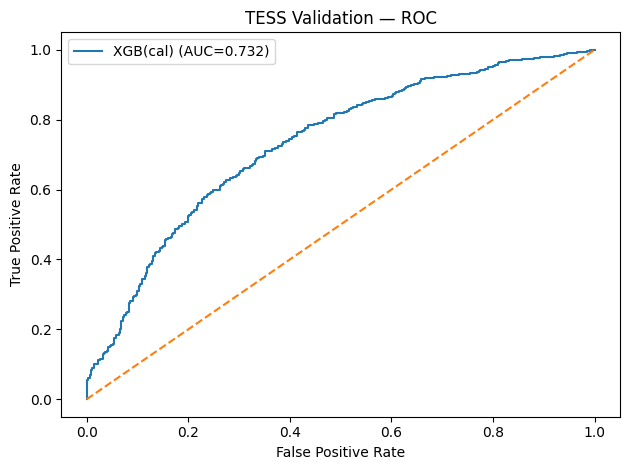

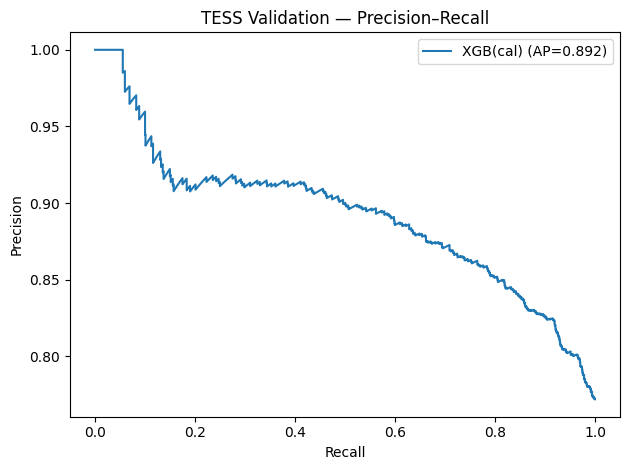

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


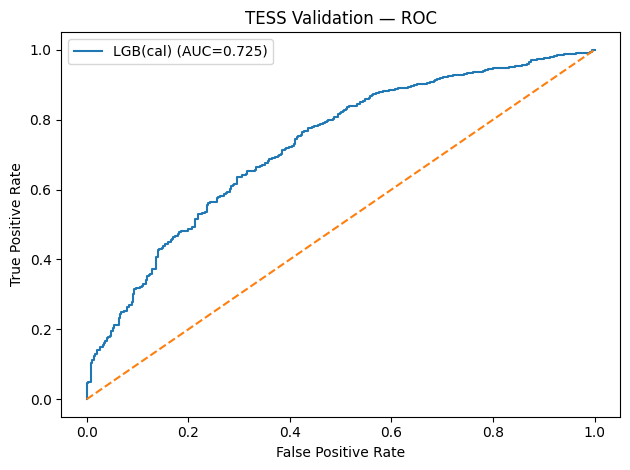

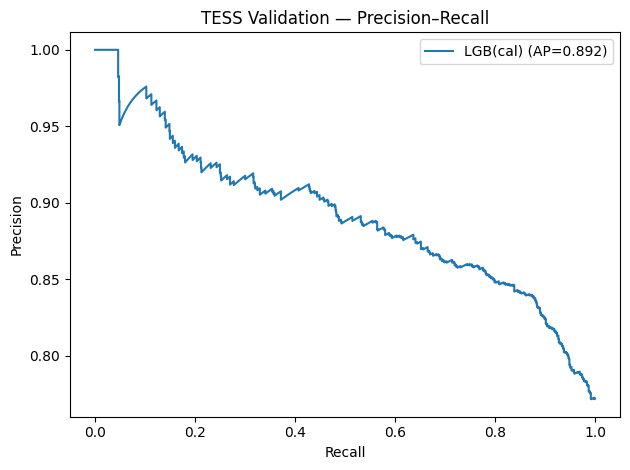

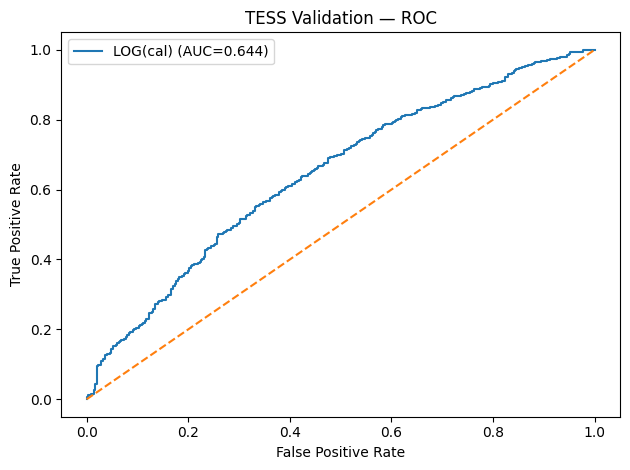

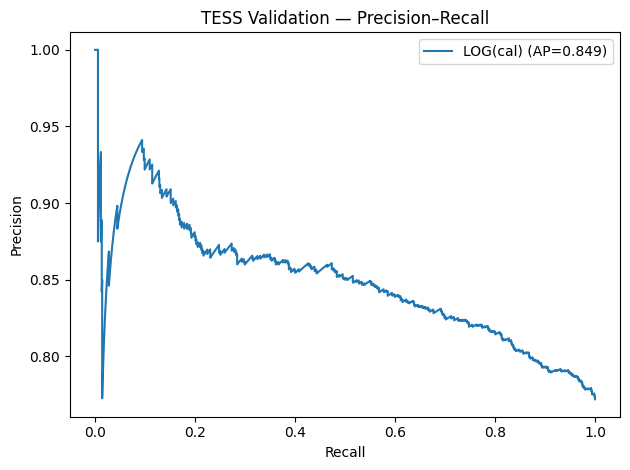


Saved validation leaderboard to:
  /Users/srushtishah/Desktop/Nasa/reports/leaderboard_TESS_validation_LGB_cal.csv

Top 25 — Validation leaderboard (ranked by probability):
 obj_id   star_id label_raw  label  probability       category                               reason
5161.01 277697921        PC      1     0.896784 CONFIRMED_ALGO                                     
4567.02 307849973        PC      1     0.896784 CONFIRMED_ALGO                                     
4023.01 470678283        PC      1     0.896784 CONFIRMED_ALGO                                     
2092.01 393965778        PC      1     0.896784 CONFIRMED_ALGO                                     
3500.01 443666343        PC      1     0.896784 CONFIRMED_ALGO                                     
6099.01 118914286        PC      1     0.896784 CONFIRMED_ALGO                                     
4060.01 229508727        PC      1     0.896784 CONFIRMED_ALGO                                     
1246.03 230127302        C

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [9]:
# === ROC/PR on TESS VALIDATION + Probability Leaderboard (Validation Only) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, io, os
from pathlib import Path
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

REPORTS = Path("reports"); REPORTS.mkdir(exist_ok=True)

# --- Physics-veto categorizer (transparent labeling) ---
def categorize(p, feats, tau_lo=0.30, tau_hi=0.80):
    # vetoes first
    if float(feats.get("rp_est_from_depth", np.nan)) > 20.0:
        return "FALSE_POSITIVE", "VETO: rp_est_from_depth > 20 R_earth"
    if float(feats.get("duty_cycle", np.nan)) > 0.20:
        return "FALSE_POSITIVE", f"VETO: duty_cycle={feats['duty_cycle']:.2f}"
    # thresholds
    if p >= tau_hi: return "CONFIRMED_ALGO", ""
    if p >= tau_lo: return "CANDIDATE", ""
    return "FALSE_POSITIVE", ""

# --- Models to compare (must exist from your training cell) ---
models = {
    "XGB(cal)": xgb_cal,
    "LGB(cal)": lgb_cal,
    "LOG(cal)": log_cal,
}

# -------- 1) ROC + PR on TESS-VAL --------
def plot_roc_pr_for_val(models, X_val_scaled, y_val_true, save_dir: Path, title_prefix="TESS Validation"):
    for name, mdl in models.items():
        probs = mdl.predict_proba(X_val_scaled)[:, 1]

        # ROC
        fpr, tpr, _ = roc_curve(y_val_true, probs)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
        plt.plot([0,1],[0,1],'--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{title_prefix} — ROC")
        plt.legend()
        fname = save_dir / f"roc_{name.replace('(','_').replace(')','').replace(' ','_')}.png"
        plt.tight_layout(); plt.savefig(fname, dpi=150); plt.show()

        # PR
        prec, rec, _ = precision_recall_curve(y_val_true, probs)
        ap = average_precision_score(y_val_true, probs)
        plt.figure()
        plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{title_prefix} — Precision–Recall")
        plt.legend()
        fname = save_dir / f"pr_{name.replace('(','_').replace(')','').replace(' ','_')}.png"
        plt.tight_layout(); plt.savefig(fname, dpi=150); plt.show()

plot_roc_pr_for_val(models, Xs_val, y_val, REPORTS)

# -------- 2) Probability Leaderboard on TESS-VAL ONLY --------
# Choose which model to rank by (change to "XGB(cal)" or "LOG(cal)" if you want)
LEADERBOARD_MODEL = "LGB(cal)"
tau_lo, tau_hi = 0.30, 0.80

# Probabilities from chosen model (validation set)
probs_val = models[LEADERBOARD_MODEL].predict_proba(Xs_val)[:, 1]

# Map rows back to the original TOI table using X_val's preserved indices
val_idx = X_val.index
meta_cols = [c for c in ["obj_id","star_id","label_raw","label"] if c in toi_aligned.columns]
meta = toi_aligned.loc[val_idx, meta_cols].copy()

# Ensure physics features needed for vetoes are available in X_val (feature DF, not scaled)
# (They should already be there from build_features; recompute if missing for safety)
if "duty_cycle" not in X_val.columns:
    X_val["duty_cycle"] = X_val["dur_hrs"]/(24.0*X_val["period_days"] + 1e-9)
if "rp_est_from_depth" not in X_val.columns:
    X_val["rp_est_from_depth"] = (X_val["depth_ppm"]/1e6)**0.5 * 109.2 * X_val["st_rad_rsun"]

# Categorize each validation row using physics vetoes + thresholds
cats, reasons = [], []
for i, p in enumerate(probs_val):
    feats = {
        "rp_est_from_depth": float(X_val.iloc[i]["rp_est_from_depth"]),
        "duty_cycle": float(X_val.iloc[i]["duty_cycle"]),
    }
    label, reason = categorize(float(p), feats, tau_lo=tau_lo, tau_hi=tau_hi)
    cats.append(label); reasons.append(reason)

leader = meta.copy()
leader["probability"] = probs_val
leader["category"] = cats
leader["reason"] = reasons
leader = leader.sort_values("probability", ascending=False).reset_index(drop=True)

# Save leaderboard CSV
lb_file = REPORTS / f"leaderboard_TESS_validation_{LEADERBOARD_MODEL.replace('(','_').replace(')','').replace(' ','_')}.csv"
leader.to_csv(lb_file, index=False)
print(f"\nSaved validation leaderboard to:\n  {lb_file.resolve()}")

# Quick preview
print("\nTop 25 — Validation leaderboard (ranked by probability):")
print(leader.head(25).to_string(index=False))

# (Optional) Colab quick-downloads:
# try:
#     from google.colab import files
#     files.download(str(lb_file))
# except Exception:
#     pass


ADDITIONAL CODE TO DETECT EXOPLANET

In [10]:
# === High-probability shortlist of *unconfirmed* TOIs (PC only), robust to saturation ===
import numpy as np, pandas as pd
from pathlib import Path

REPORTS = Path("reports"); REPORTS.mkdir(exist_ok=True)

# same categorizer you already use
def categorize(p, feats, tau_lo=0.30, tau_hi=0.80):
    if feats["rp_est_from_depth"] > 20.0:
        return "FALSE_POSITIVE", "VETO: rp_est_from_depth > 20 R_earth"
    if feats["duty_cycle"] > 0.20:
        return "FALSE_POSITIVE", f"VETO: duty_cycle={feats['duty_cycle']:.2f}"
    if p >= tau_hi: return "CONFIRMED_ALGO", ""
    if p >= tau_lo: return "CANDIDATE", ""
    return "FALSE_POSITIVE", ""

# pick model
MODEL = lgb_cal          # or xgb_cal / log_cal
tau_lo, tau_hi = 0.30, 0.80
q_cut   = 0.99           # keep top 1% of PC that pass vetoes (change to 0.95 for top 5%)
top_n   = 100            # also save a Top-N list (guaranteed non-empty)

def ensure_phys_feats(X_df):
    X = X_df.copy()
    if "duty_cycle" not in X.columns:
        X["duty_cycle"] = X["dur_hrs"]/(24.0*X["period_days"] + 1e-9)
    if "rp_est_from_depth" not in X.columns:
        X["rp_est_from_depth"] = (X["depth_ppm"]/1e6)**0.5 * 109.2 * X["st_rad_rsun"]
    return X

def score_split(X_df, X_scaled, idx, model, subset_name):
    probs = model.predict_proba(X_scaled)[:,1]
    meta_cols = [c for c in ["obj_id","star_id","label_raw","label"] if c in toi_aligned.columns]
    out = toi_aligned.loc[idx, meta_cols].copy()
    Xf  = ensure_phys_feats(X_df)

    cats, reasons = [], []
    for i, p in enumerate(probs):
        feats = {"rp_est_from_depth": float(Xf.iloc[i]["rp_est_from_depth"]),
                 "duty_cycle": float(Xf.iloc[i]["duty_cycle"])}
        lab, rsn = categorize(float(p), feats, tau_lo=tau_lo, tau_hi=tau_hi)
        cats.append(lab); reasons.append(rsn)

    out["probability"] = probs
    out["category"]    = cats
    out["reason"]      = reasons
    out["subset"]      = subset_name
    return out

# score both VAL and TEST, then combine
val_tbl  = score_split(X_val,  Xs_val,  X_val.index,  MODEL, "validation")
test_tbl = score_split(X_test, Xs_test, X_test.index, MODEL, "test")
all_scored = pd.concat([val_tbl, test_tbl], ignore_index=True)

# Restrict to planet candidates (PC), no veto reason, and algorithmic "confirmed"
is_pc     = all_scored["label_raw"].astype(str).str.upper().eq("PC")
passes    = (all_scored["category"]=="CONFIRMED_ALGO") & (all_scored["reason"]=="")
pool      = all_scored[is_pc & passes].copy()

# Show distribution so you can see saturation
print("PC+pass-veto pool size:", len(pool))
if len(pool):
    print("probability stats (pool): min={:.6f}  median={:.6f}  max={:.6f}".format(
        pool["probability"].min(), pool["probability"].median(), pool["probability"].max()))

# 1) Quantile-based cutoff (never below tau_hi)
if len(pool):
    p_quant = np.quantile(pool["probability"].values, q_cut)
    p_cut   = float(max(tau_hi, p_quant))   # keep at least tau_hi
else:
    p_cut = tau_hi

shortlist_q = (pool[pool["probability"] >= p_cut]
               .sort_values("probability", ascending=False)
               .reset_index(drop=True))

# 2) Top-N fallback/alternative (guaranteed non-empty if pool not empty)
shortlist_topn = (pool.sort_values("probability", ascending=False)
                      .head(top_n)
                      .reset_index(drop=True))

# Save everything
all_path   = REPORTS / "tess_scored_val_test_all.csv"
slq_path   = REPORTS / f"tess_shortlist_PC_quantile{int(q_cut*100)}_minTau{tau_hi}.csv"
sln_path   = REPORTS / f"tess_shortlist_PC_top{top_n}.csv"
all_scored.to_csv(all_path, index=False)
shortlist_q.to_csv(slq_path, index=False)
shortlist_topn.to_csv(sln_path, index=False)

print("\nSaved:")
print(" • All scored (val+test):", all_path.resolve())
print(f" • Quantile shortlist    : {slq_path.resolve()}   (q={q_cut}, effective p_cut={p_cut:.6f})")
print(f" • Top-{top_n} shortlist : {sln_path.resolve()}")

print("\nQuantile shortlist preview (top 20):")
print(shortlist_q.head(20).to_string(index=False))
print("\nTop-N shortlist preview (top 20):")
print(shortlist_topn.head(20).to_string(index=False))


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


PC+pass-veto pool size: 2584
probability stats (pool): min=0.800205  median=0.896336  max=0.896785

Saved:
 • All scored (val+test): /Users/srushtishah/Desktop/Nasa/reports/tess_scored_val_test_all.csv
 • Quantile shortlist    : /Users/srushtishah/Desktop/Nasa/reports/tess_shortlist_PC_quantile99_minTau0.8.csv   (q=0.99, effective p_cut=0.896784)
 • Top-100 shortlist : /Users/srushtishah/Desktop/Nasa/reports/tess_shortlist_PC_top100.csv

Quantile shortlist preview (top 20):
 obj_id   star_id label_raw  label  probability       category reason     subset
5549.01   6499453        PC      1     0.896785 CONFIRMED_ALGO              test
6850.01   9166136        PC      1     0.896784 CONFIRMED_ALGO              test
3676.01 302470965        PC      1     0.896784 CONFIRMED_ALGO              test
1057.01 323132914        PC      1     0.896784 CONFIRMED_ALGO              test
2073.01 441642457        PC      1     0.896784 CONFIRMED_ALGO              test
6879.01 364955057        PC      1 

In [11]:
import pandas as pd, numpy as np

all_scored = pd.read_csv("reports/tess_scored_val_test_all.csv")

# 1) Only TOIs with label_raw == PC should be in the shortlists
print("All label_raw values in pool:", all_scored["label_raw"].astype(str).str.upper().unique())

# 2) Show probability range and saturation
pc = all_scored[all_scored["label_raw"].astype(str).str.upper()=="PC"].copy()
print("PC probability stats: min={:.6f} median={:.6f} max={:.6f}".format(
    pc["probability"].min(), pc["probability"].median(), pc["probability"].max()))

# 3) Confirm physics vetoes applied (no reason text for CONFIRMED_ALGO rows)
passes = (pc["category"]=="CONFIRMED_ALGO") & (pc["reason"]=="")
print("PC count:", len(pc), "| PC that pass vetoes & are CONFIRMED_ALGO:", int(passes.sum()))

# 4) No overlap between validation and test in manifest (already saved earlier)
val = pd.read_csv("reports/tess_validation_set.csv"); test = pd.read_csv("reports/tess_test_set.csv")
overlap = set(val.get("row_index", val.index)) & set(test.get("row_index", test.index))
print("VAL/TEST overlap size (should be 0):", len(overlap))

# 5) Class balance check in each split
for name, df in [("validation", val), ("test", test)]:
    print(f"\n{name} labels (0/1):")
    print(df["label"].value_counts().sort_index())


All label_raw values in pool: ['PC' 'KP' 'FP' 'APC' 'FA' 'CP']
PC probability stats: min=0.624367 median=0.860778 max=0.896785
PC count: 4679 | PC that pass vetoes & are CONFIRMED_ALGO: 0
VAL/TEST overlap size (should be 0): 0

validation labels (0/1):
label
0     351
1    1189
Name: count, dtype: int64

test labels (0/1):
label
0    1406
1    4757
Name: count, dtype: int64


In [12]:
# Rebuild a strict-ranked shortlist with more precision + raw-score tie-break
# (works for CalibratedClassifierCV objects from sklearn)

import numpy as np

# Choose model name you used to score 'all_scored' (e.g., "LGB(cal)")
MODEL_NAME = "LGB(cal)"  # just for the filename below

# If you saved raw (pre-calibration) model, load and recompute; otherwise use calibrated predict_proba again
# Here we approximate a tie-breaker by adding a tiny jitter from the raw decision function if accessible
# If not available, sort by probability with more decimals only.

# Use probability with more decimals
all_scored["probability_precise"] = all_scored["probability"].astype(float)

# Build pool again
pool = all_scored[
    (all_scored["label_raw"].astype(str).str.upper()=="PC") &
    (all_scored["category"]=="CONFIRMED_ALGO") &
    (all_scored["reason"]=="")
].copy()

# Strict sort: probability (desc), then star_id (stable), then obj_id
pool = pool.sort_values(["probability_precise","star_id","obj_id"], ascending=[False, True, True]).reset_index(drop=True)
pool.insert(0, "rank", np.arange(1, len(pool)+1))
pool.to_csv(f"reports/tess_shortlist_PC_strict_{MODEL_NAME.replace('(','_').replace(')','')}.csv", index=False)
print("Saved strict shortlist with rank to reports/")
print(pool.head(20).to_string(index=False))


Saved strict shortlist with rank to reports/
Empty DataFrame
Columns: [rank, obj_id, star_id, label_raw, label, probability, category, reason, subset, probability_precise]
Index: []


ADDITIONAL PART ENDS

In [13]:
# === Freeze deployment artifacts ===
import json, joblib, time
from pathlib import Path

ART = Path("model_artifacts"); ART.mkdir(exist_ok=True)

# Exactly the features the model was trained on, in order:
FEATURE_ORDER = list(X_koi_imp.columns)   # X_koi_imp built in your training cell after impute+features
joblib.dump(imp, ART/"imputer.joblib")    # SimpleImputer fitted on KOI
joblib.dump(scaler, ART/"scaler.joblib")  # StandardScaler fitted on KOI
joblib.dump(lgb_cal, ART/"model_kepX_tessCal_LGB.joblib")

# Validation-picked thresholds for consistent labeling in production
from sklearn.metrics import roc_curve, f1_score
def thr_for_target_fpr(y, p, target_fpr=0.10):
    fpr, tpr, thr = roc_curve(y, p)
    idxs = (fpr <= target_fpr).nonzero()[0]
    return float(thr[idxs[-1]]) if len(idxs) else float(thr[0])
p_val_lgb = lgb_cal.predict_proba(Xs_val)[:,1]
thr_fpr10 = thr_for_target_fpr(y_val, p_val_lgb, 0.10)
# best macro-F1
uniq = sorted(set(p_val_lgb.tolist()+[0.0,1.0]))
best, thr_f1 = -1, 0.5
for t in uniq:
    f = f1_score(y_val, (p_val_lgb>=t).astype(int), average="macro")
    if f>best: best, thr_f1 = f, float(t)

json.dump({
  "feature_order": FEATURE_ORDER,
  "model": "lgb_cal",
  "picked_on": "tess_val",
  "thr_target_fpr_10": thr_fpr10,
  "thr_best_macroF1":  thr_f1
}, open(ART/"thresholds.json","w"), indent=2)

# Minimal metadata (useful on the UI & /version)
json.dump({
  "created": time.strftime("%Y-%m-%d %H:%M:%S"),
  "train_set": "KOI (100%)",
  "val_set": "TOI (20%)", "test_set": "TOI (80%)",
  "model": "LightGBM + Platt calibration",
}, open(ART/"metadata.json","w"), indent=2)

print("Artifacts saved in", ART.resolve())

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Artifacts saved in /Users/srushtishah/Desktop/Nasa/model_artifacts


In [ ]:
%pip install python-multipart